## FASHION MNIST

### **Importing important libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import struct22211221111221221111111111112
import pandas as pd11qq11212wwwwqqqqw
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We import torch, nn and functional modules to create our models \
We import DataLoader and Dataset for loading the dataset and for making train and test loader for our model\
We import transforms and optim for image transformations and optimization algorithms for training NN\
We import pandas for data manipulation and analysis and time for measuring time intervals\
And matplotlib is used for data visualizations

**If the GPU is available use it for the computation otherwise use the CPU.**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Loading the data**


Create a custom dataset class called for loading Fashion MNIST images and labels from binary files. 

In [3]:
class FashionMNISTDataset(Dataset):
    #constructor method 
    def __init__(self, image_file, label_file, transform=None):
        self.transform = transform
        self.images = self.load_images(image_file)
        self.labels = self.load_labels(label_file)

    def __len__(self):
        return len(self.labels)
    
    #return image & label corres. to given idx 
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    #helper function for loading images and labels from binary files
    def load_images(self, image_file):
        with open(image_file, 'rb') as f:
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
            return images

    def load_labels(self, label_file):
        with open(label_file, 'rb') as f:
            magic, num_labels = struct.unpack('>II', f.read(8))
            labels = np.fromfile(f, dtype=np.uint8)
            return labels


Transform pipeline for Converting images to pytorch tensors and normalizing the images

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
import os
def get_file_path(file_name):
    # Get the current directory
    current_dir = os.getcwd()
    
    # Specify the relative path to the data folder from the current directory
    data_folder = os.path.join(current_dir, '../data')
    
    # Construct the full file path by joining the data folder path with the file name
    file_path = os.path.join(data_folder, file_name)
    
    return file_path

train_image_file = get_file_path('train-images-idx3-ubyte')
train_label_file = get_file_path('train-labels-idx1-ubyte')
test_image_file = get_file_path('t10k-images-idx3-ubyte')
test_label_file = get_file_path('t10k-labels-idx1-ubyte')

train_dataset = FashionMNISTDataset(train_image_file, train_label_file, transform=transform)
test_dataset = FashionMNISTDataset(test_image_file, test_label_file, transform=transform)

#Load the data for training 
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Exploring the data

In [6]:
#Fuction to map label no. to name
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input_label = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input_label]


In [7]:
#shape of a batch
batch_images, batch_labels = next(iter(train_loader))
print(batch_images.size())
print(batch_labels.size())

torch.Size([64, 1, 28, 28])
torch.Size([64])


Image dimensions are 28x28 pixels 

In [8]:
image_index = 0
image, label = train_dataset[image_index]
print("Image shape:", image.shape)

Image shape: torch.Size([1, 28, 28])


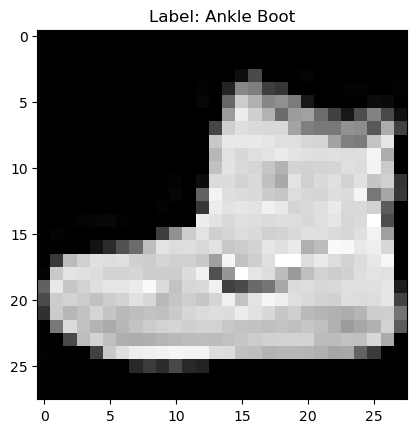

In [9]:
image, label = next(iter(train_dataset))
label=output_label(label)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f'Label: {label}')

plt.show()

In [10]:
train_dataset_size = len(train_dataset)
print("Train dataset size:", train_dataset_size)

test_dataset_size = len(test_dataset)
print("Test dataset size:", test_dataset_size)

Train dataset size: 60000
Test dataset size: 10000


The training set is of 60000 images having 28X28 dimension and test set is of 10000 images having 28X28 dimension

In [11]:
train_null_values = np.isnan(train_dataset.images).sum()
print("Null values in train set:", train_null_values)

test_null_values = np.isnan(test_dataset.images).sum()
print("Null values in test set:", test_null_values)

Null values in train set: 0
Null values in test set: 0


Since there are no null values in train and test set ,we can head directly to model building

## Building a CNN 


*   Make a model class (CNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in both layers. Stride of 1 in both layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 .
         
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 2 Fully connected layer  with different in/out features.
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 1, output: 28 \* 28 \* 16
        * First Max Pooling layer : input: 28 \* 28 \* 16, output: 14 \* 14 \* 16
        * Second Conv layer : input : 14 \* 14 \* 16, output: 14 \* 14 \* 32
        * Second Max Pooling layer : 14 \* 14\* 32, output:  7 \* 7\* 32
    * Final fully connected layer has 10 output features for 10 types of clothes.
* These convolutional and pooling layers help extract relevant features from the input images.

In [12]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [13]:
#checking the model
from torchsummary import summary
model=CNN()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 128]         200,832
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.33
Params size (MB): 0.79
Estimated Total Size (MB): 1.12
-------------------------------------------

In [14]:
#fucntion for performing the training loop 
def train(model, loader, optimizer, criterion, device):
    model.train() #set to training mode

    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loader): #iterate over batches
        # Transfering images and labels to GPU if available
        data, target = data.to(device), target.to(device)
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        # Forward pass 
        output = model(data)
        loss = criterion(output, target)
        #Propagating the error backward
        loss.backward()
        # Optimizing the parameters
        optimizer.step()
        running_loss += loss.item()
        _, predicted = output.max(1) #Determine the predicted labels by selecting the class with the highest probability
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    train_loss = running_loss / len(loader) #avg loss
    train_accuracy = 100.0 * correct / total
    return train_loss, train_accuracy

#fucntion to evaluate the performance of a trained model
def test(model, loader, criterion, device):
    model.eval() #Set the model in evaluation mode 
    test_loss = 0.0
    correct = 0
    with torch.no_grad(): #disable gradient calculation and backpropagation during eval
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data) #forward pass
            test_loss += criterion(output, target).item() #calc avg loss between the predicted output and the truth labels.
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() #no. of correct predictions
    test_loss /= len(loader.dataset)
    accuracy = 100.0 * correct / len(loader.dataset)
    return test_loss, accuracy

#function for handling training of model and other parameters
def run_model(model, train_loader, criterion, optimizer, device, use_ipex=False):
    if use_ipex:
        #apply intel optimization for pytorch
        import intel_extension_for_pytorch as ipex
        model, optimizer = ipex.optimize(model, optimizer=optimizer)

    model.to(device)

    train_losses = []
    train_accuracies = []
    inference_times = []

    for epoch in range(epochs): #Iterates over the specified number of epochs
        model.train()
        start_time = time.time() #starting time for measuring the epoch time
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device) #perform training for one epoch
        inference_time = time.time() - start_time #calc epoch time

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        inference_times.append(inference_time)

        print(f'Epoch: {epoch+1}/{epochs}\t'  
              f'Train Loss: {train_loss:.4f}\t'
              f'Train Accuracy: {train_accuracy:.2f}%\t'
              f'Epoch Time: {inference_time:.2f} seconds') #Time taken to train on 1 epoch 

    return model, train_losses, train_accuracies, inference_times



### Training the network

In [26]:
#define epoch size
epochs = 12

#Defining a Loss function
#CrossEntropyLoss is commonly used for multi-class classification problems
criterion = nn.CrossEntropyLoss()
model_no_ipex = CNN()  #creates an instance of the CNN model
#Using Adam algorithm for optimization purpose with learning rate of 0.001
optimizer_no_ipex = optim.Adam(model_no_ipex.parameters(), lr=0.001) 

model_ipex = CNN()
optimizer_ipex = optim.Adam(model_ipex.parameters(), lr=0.001)

#Train the model without ipex optimization
model_no_ipex, train_losses_no_ipex, train_accuracies_no_ipex, inference_times_no_ipex = \
    run_model(model_no_ipex, train_loader, criterion, optimizer_no_ipex, device, use_ipex=False)
#Train the model with ipex optimization
model_ipex, train_losses_ipex, train_accuracies_ipex, inference_times_ipex = \
    run_model(model_ipex, train_loader, criterion, optimizer_ipex, device, use_ipex=True)

Epoch: 1/12	Train Loss: 0.4777	Train Accuracy: 82.74%	Epoch Time: 8.85 seconds
Epoch: 2/12	Train Loss: 0.3106	Train Accuracy: 88.72%	Epoch Time: 8.79 seconds
Epoch: 3/12	Train Loss: 0.2626	Train Accuracy: 90.26%	Epoch Time: 8.78 seconds
Epoch: 4/12	Train Loss: 0.2305	Train Accuracy: 91.54%	Epoch Time: 8.77 seconds
Epoch: 5/12	Train Loss: 0.2073	Train Accuracy: 92.41%	Epoch Time: 8.77 seconds
Epoch: 6/12	Train Loss: 0.1873	Train Accuracy: 92.93%	Epoch Time: 8.76 seconds
Epoch: 7/12	Train Loss: 0.1688	Train Accuracy: 93.69%	Epoch Time: 8.81 seconds
Epoch: 8/12	Train Loss: 0.1549	Train Accuracy: 94.28%	Epoch Time: 8.76 seconds
Epoch: 9/12	Train Loss: 0.1408	Train Accuracy: 94.76%	Epoch Time: 8.76 seconds
Epoch: 10/12	Train Loss: 0.1244	Train Accuracy: 95.30%	Epoch Time: 8.77 seconds
Epoch: 11/12	Train Loss: 0.1136	Train Accuracy: 95.72%	Epoch Time: 8.75 seconds
Epoch: 12/12	Train Loss: 0.0984	Train Accuracy: 96.35%	Epoch Time: 8.76 seconds
Epoch: 1/12	Train Loss: 0.4648	Train Accuracy: 83

We can notice that due to IPEX optimization ,there is also sometimes effect on Epoch time of model,which can decrease upto 3 secs

### Testing the trained model on Test dataset

In [27]:
#Save both the models
current_dir = os.getcwd()
model_folder = os.path.join(current_dir, '../model')

model_path_no_ipex = os.path.join(model_folder,'model_no_ipex.pt')
model_path_ipex = os.path.join(model_folder,'model_ipex.pt')

torch.save(model_no_ipex.state_dict(),model_path_no_ipex)
torch.save(model_ipex.state_dict(), model_path_ipex)

#Evaluate the model on test set
model_no_ipex.eval()
start_time_no_ipex = time.time()#starting time for measuring the inference time
test_loss_no_ipex, test_accuracy_no_ipex = test(model_no_ipex, test_loader, criterion, device)
inference_time_no_ipex = time.time() - start_time_no_ipex #calc inference time
print(f'Test Loss (No IPEX): {test_loss_no_ipex:.4f}\tAccuracy (No IPEX): {test_accuracy_no_ipex:.2f}%\tInference time(No IPEX): {inference_time_no_ipex:.3f}')

model_ipex.eval()
start_time_ipex = time.time()
test_loss_ipex, test_accuracy_ipex = test(model_ipex, test_loader, criterion, device)
inference_time_ipex = time.time() - start_time_ipex
print(f'Test Loss (IPEX): {test_loss_ipex:.4f}\tAccuracy (IPEX): {test_accuracy_ipex:.2f}% \tInference time(IPEX): {inference_time_ipex:.3f}')


Test Loss (No IPEX): 0.0044	Accuracy (No IPEX): 91.55%	Inference time(No IPEX): 1.006
Test Loss (IPEX): 0.0045	Accuracy (IPEX): 91.61% 	Inference time(IPEX): 0.914


### Model Analysis

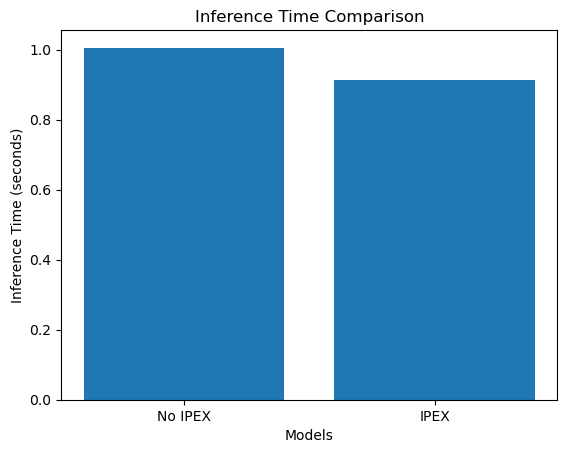

In [28]:
# Plotting a bar graph comparing inference times of both models(IPEX optimized and Without Optimization) 
models = ['No IPEX', 'IPEX']
inference_times = [inference_time_no_ipex, inference_time_ipex]

plt.bar(models, inference_times)
plt.xlabel('Models')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.show()

We can see that with ipex optimization the inference time of CNN model decreases by almost 0.2-0.5 secs and accuracy and loss also tend to increase and decrease respectively

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import label_binarize #convert target labels into binary matrix representation

In [30]:
#obtain predictions and targets and convert them to human readable names
def get_predictions(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
             # Get the predicted labels by finding the maximum values along the second dimension (class probabilities)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy()) #convert to numpy arrays and extend the lists
            targets.extend(target.cpu().numpy())
           
    return np.array(predictions), np.array(targets)


# Get predictions and targets for test set
predictions, targets = get_predictions(model_ipex, test_loader, device)

label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Convert the predicted and target labels to human-readable names
predicted_labels_ipex = [label_names[pred] for pred in predictions]
target_labels_ipex = [label_names[target] for target in targets]


##### Confusion Matrix

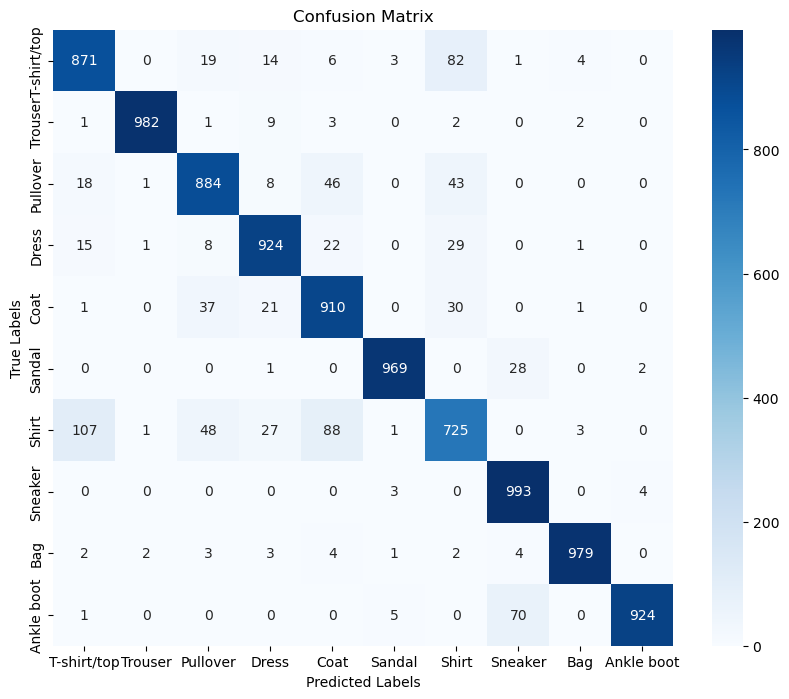

In [31]:
"""visual representation of how well the model is performing for each class 
  in terms of classification accuracy and potential misclassifications"""
cm = confusion_matrix(target_labels_ipex,predicted_labels_ipex,labels=label_names)
plt.figure(figsize=(10, 8))
# visualize the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Model is able to accurately predict the accessories and bottom wear classes ,while it faces difficulties in predicting the classes of Top wear.
Almost 10% of shirts and T-shirts are incorrectly classified as each other

##### Classification Report

In [32]:
target_names = [output_label(i) for i in range(10)]
classification_rep = classification_report(targets, predictions, target_names=target_names)
print('Classification Report:')
print(classification_rep)

#Precision is defined as the ratio of true positives to the sum of true and false positives.
#Recall is defined as the ratio of true positives to the sum of true positives and false negatives
#F1 is the weighted harmonic mean of precision and recall,closer the F1 score is to 1, the better the expected performance of the model is.
#support indicates the number of occurrences of each class in the dataset

#macro avg calculates the average metrics across all classes without considering class imbalance
#weighted avg calculates the average metrics weighted by the number of samples in each class, accounting for class imbalance.

Classification Report:
              precision    recall  f1-score   support

 T-shirt/Top       0.86      0.87      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.88      0.88      0.88      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.84      0.91      0.88      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.79      0.72      0.76      1000
     Sneaker       0.91      0.99      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle Boot       0.99      0.92      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



The best accuracy is obtained for Trouser,Sneaker, Sandal, Bag and Ankle Boot. Worst accuracy is for Shirt.

The recall is highest for Trouser, Sandal and smallest for Shirt and Pullover.

f1-score is highest for Trouser1, Bag  and Sandal and smallest for Shirt followed by Pullover and T-Shirt.

We can see that "Trouser" class exhibits perfect precision, recall, and F1-score, suggesting that the model performs exceptionally well for this class
Model suffers in case of some classes, such as "Shirt" and "Coat".

##### ROC CURVE 

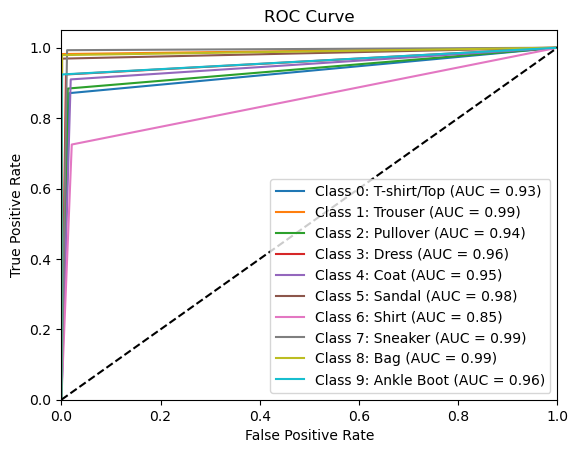

In [33]:
#ROC plotted here is in One-vs-Rest scheme compares each class against all the others (assumed as one)
#The higher the AUC score, the better the model
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions and targets in one-hot encoded format
predictions_one_hot = np.eye(len(label_names))[predictions]
targets_one_hot = np.eye(len(label_names))[targets]

# Calculate the false positive rate (FPR) and true positive rate (TPR) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], predictions_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
for i in range(len(label_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i}: {output_label(i)} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


##### IOU Plot

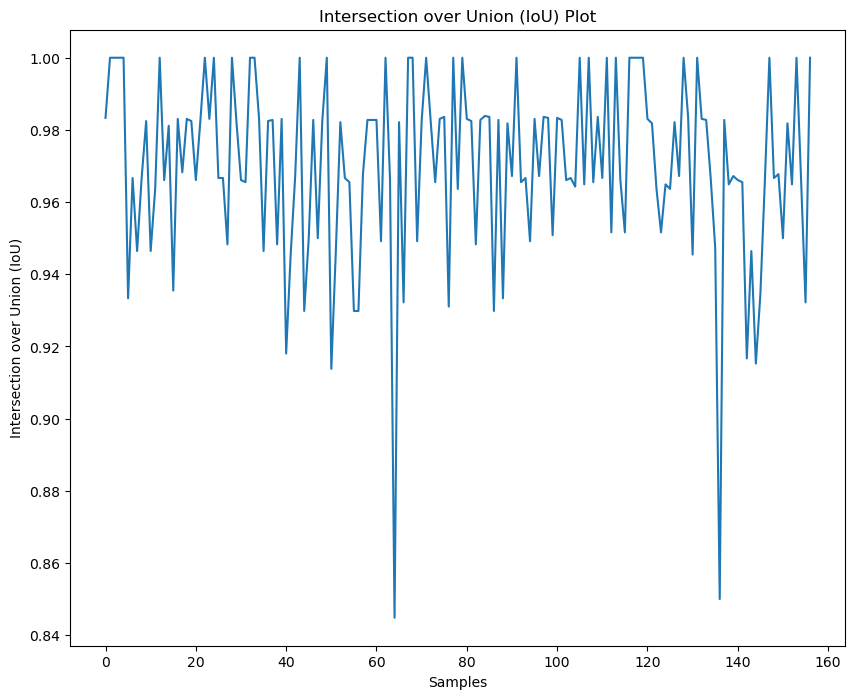

In [34]:
#calculates the Intersection over Union (IoU) score for each sample in the test dataset and plot the scores
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
"""IoU is calculated as the ratio of the intersection area 
between the predicted and ground truth regions to the union area of these regions,however it doesnt have much use in image classifcation """
iou_scores = []

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)  #forward pass
    output = model_ipex(data)
    _, predicted = torch.max(output, 1) # get predicted class labels
    iou_scores.append(iou(target.cpu().numpy(), predicted.cpu().numpy())) #Converts tensors to NumPy arrays 

plt.figure(figsize=(10, 8))
plt.plot(range(len(iou_scores)), iou_scores)
plt.xlabel('Samples')
plt.ylabel('Intersection over Union (IoU)')
plt.title('Intersection over Union (IoU) Plot')
plt.show()

##### Looking the Accuracy in each class of FashionMNIST dataset

In [35]:
class_accuracy = {}  # Create an empty dictionary to store class accuracies
for class_name in label_names:
    class_idx = label_names.index(class_name)
    class_total = target_labels_ipex.count(class_name)
    #Count the number of correctly classified samples for the current class
    class_correct = sum(1 for i in range(len(target_labels_ipex)) if target_labels_ipex[i] == class_name and predicted_labels_ipex[i] == class_name)
    class_accuracy[class_name] = 100.0 * class_correct / class_total

for class_name, accuracy in class_accuracy.items():
    print(f'Accuracy for {class_name}: {accuracy:.2f}%')

Accuracy for T-shirt/top: 87.10%
Accuracy for Trouser: 98.20%
Accuracy for Pullover: 88.40%
Accuracy for Dress: 92.40%
Accuracy for Coat: 91.00%
Accuracy for Sandal: 96.90%
Accuracy for Shirt: 72.50%
Accuracy for Sneaker: 99.30%
Accuracy for Bag: 97.90%
Accuracy for Ankle boot: 92.40%


Here, it can be seen that model is able to predict most of classes accurately except Shirt and T-Shirt and Pullover, which makes sense as all 3 of them are quite similar in appearance

##### Visualizing classified images along with their corresponding labels and predictions 

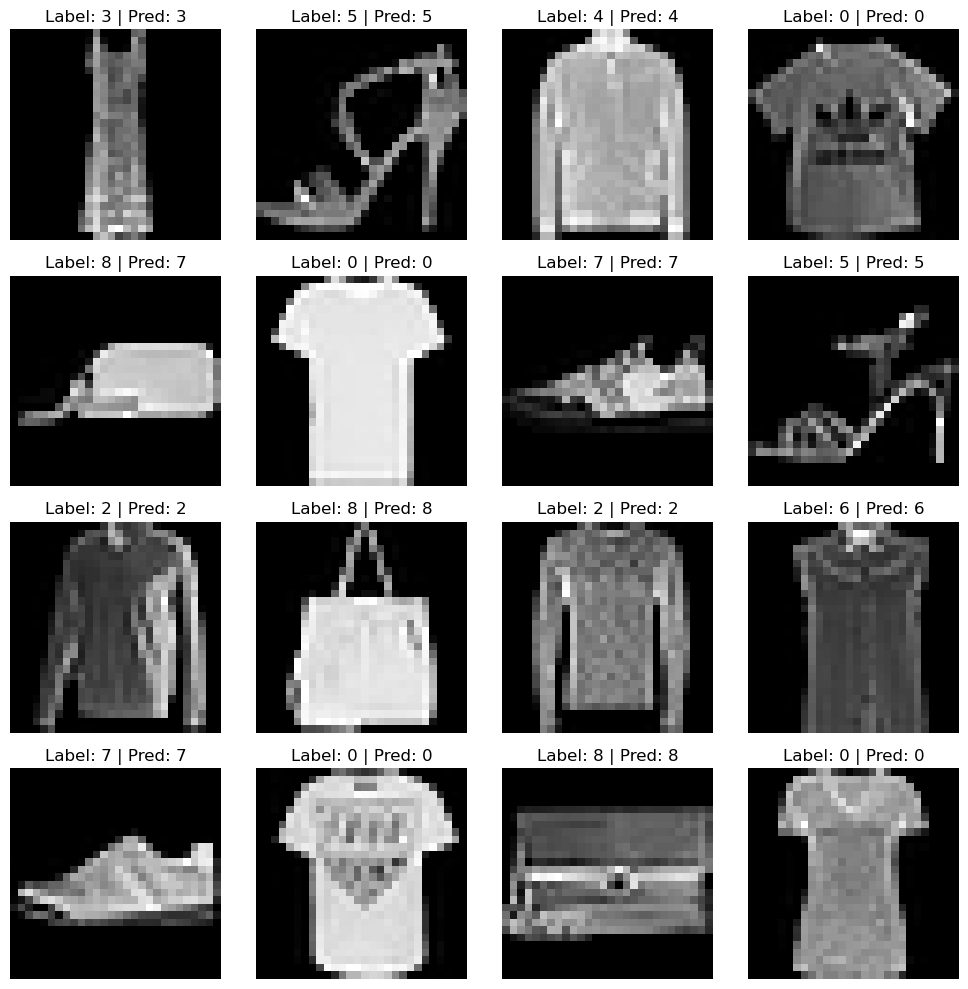

In [37]:
import random

model_ipex.eval()

# Create a random subset of the test dataset
subset_indices = random.sample(range(len(test_dataset)), 16)
subset = torch.utils.data.Subset(test_dataset, subset_indices)

with torch.no_grad():
    subset_loader = torch.utils.data.DataLoader(subset, batch_size=16, shuffle=False)
    images, labels = next(iter(subset_loader))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ipex(images)
    _, predicted = torch.max(outputs.data, 1)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title("Label: {} | Pred: {}".format(labels[i].item(), predicted[i].item()))
        ax.axis('off')

    plt.tight_layout()
    plt.show()


From the above grid ,it can be seen that the Model is able to predict most of the Images in the dataset with few incorrectly classified images , with an average accuracy of 91.5%\
Hence we have successfully performed image classification on the fashion MNIST dataset.